In [1]:
# Diffusion using DDPM on MNIST

import math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# -----------------------------
# Device
# -----------------------------

def set_seed(seed=2026):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, "| GPU:", torch.cuda.get_device_name(0) if device.type == "cuda" else "None")


Device: cuda | GPU: NVIDIA A100-SXM4-40GB


In [8]:
# -----------------------------
# Data (MNIST, grayscale, normalized to [-1, 1])
# -----------------------------

IMG_SIZE = 32  # use 32x32 for clean down/up sampling
BATCH_SIZE = 128

tfm = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # [0,1] -> [-1,1]
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, pin_memory=(device.type == "cuda"), drop_last=True
)


In [9]:
# -----------------------------
# Diffusion schedule (linear betas_t)
# -----------------------------

T = 400
beta_start, beta_end = 1e-4, 0.02

betas = torch.linspace(beta_start, beta_end, T, device=device)              # [T]
alphas = 1.0 - betas                                                       # [T]
alpha_bar = torch.cumprod(alphas, dim=0)                                   # [T]
alpha_bar_prev = torch.cat([torch.ones(1, device=device), alpha_bar[:-1]]) # [T]

sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - alpha_bar)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# posterior variance: beta_tilde_t = beta_t * (1 - alpha_bar_{t-1}) / (1 - alpha_bar_t)
posterior_variance = betas * (1.0 - alpha_bar_prev) / (1.0 - alpha_bar)
posterior_variance = torch.clamp(posterior_variance, min=1e-20)

def extract(a_1d, t, x_shape):
    # a_1d: [T], t: [B] long -> returns [B,1,1,1] for broadcasting
    out = a_1d.gather(0, t)
    return out.view(-1, 1, 1, 1)

def q_sample(x0, t, noise):
    # x_t = sqrt(alpha_bar_t)*x0 + sqrt(1-alpha_bar_t)*eps
    return extract(sqrt_alpha_bar, t, x0.shape) * x0 + extract(sqrt_one_minus_alpha_bar, t, x0.shape) * noise


In [13]:
# -----------------------------
# UNet with sinusoidal time embedding
# -----------------------------

def timestep_embedding(timesteps, dim, max_period=10000):
    """Sinusoidal timestep embeddings. timesteps: [B] -> [B, dim]."""
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(0, half, dtype=torch.float32, device=timesteps.device) / half
    )
    args = timesteps.float()[:, None] * freqs[None]
    emb = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb

def _gn_groups(ch: int) -> int:
    # pick a GroupNorm group count that divides ch
    for g in (32, 16, 8, 4, 2, 1):
        if ch % g == 0:
            return g
    return 1

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, temb_dim, dropout=0.1):
        super().__init__()
        g1 = _gn_groups(in_ch)
        g2 = _gn_groups(out_ch)
        self.norm1 = nn.GroupNorm(g1, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(g2, out_ch)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.temb_proj = nn.Linear(temb_dim, out_ch)
        self.skip = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x, temb):
        h = self.conv1(F.silu(self.norm1(x)))
        h = h + self.temb_proj(F.silu(temb))[:, :, None, None]
        h = self.conv2(self.dropout(F.silu(self.norm2(h))))
        return h + self.skip(x)

class AttnBlock(nn.Module):
    """Simple full attention over spatial positions (good at 8x8 / 16x16)."""
    def __init__(self, ch, num_heads=4):
        super().__init__()
        assert ch % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = ch // num_heads
        self.norm = nn.GroupNorm(_gn_groups(ch), ch)
        self.qkv = nn.Conv2d(ch, 3 * ch, 1)
        self.proj = nn.Conv2d(ch, ch, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        n = h * w
        x0 = x
        x = self.norm(x)
        qkv = self.qkv(x)  # [B, 3C, H, W]
        q, k, v = qkv.chunk(3, dim=1)

        # [B, heads, head_dim, N]
        q = q.view(b, self.num_heads, self.head_dim, n)
        k = k.view(b, self.num_heads, self.head_dim, n)
        v = v.view(b, self.num_heads, self.head_dim, n)

        # attention: [B, heads, N, N]
        scale = 1.0 / math.sqrt(self.head_dim)
        attn = torch.softmax((q.transpose(-2, -1) @ k) * scale, dim=-1)
        out = (attn @ v.transpose(-2, -1)).transpose(-2, -1)  # [B, heads, head_dim, N]
        out = out.reshape(b, c, h, w)
        out = self.proj(out)
        return x0 + out

class BiggerUNet(nn.Module):
    """
    32x32: 32 -> 16 -> 8 -> 4 bottleneck, 2 ResBlocks per level, attention at 16 & 8.
    """
    def __init__(self, in_ch=1, base=96, temb_dim=512, dropout=0.1, attn_heads=4):
        super().__init__()
        self.temb_dim = temb_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(temb_dim, temb_dim),
            nn.SiLU(),
            nn.Linear(temb_dim, temb_dim),
        )

        self.in_conv = nn.Conv2d(in_ch, base, 3, padding=1)

        # Down: 32 -> 16 -> 8 -> 4
        self.d1a = ResBlock(base, base, temb_dim, dropout)
        self.d1b = ResBlock(base, base, temb_dim, dropout)
        self.down1 = nn.Conv2d(base, base * 2, 4, stride=2, padding=1)

        self.d2a = ResBlock(base * 2, base * 2, temb_dim, dropout)
        self.d2b = ResBlock(base * 2, base * 2, temb_dim, dropout)
        self.attn16 = AttnBlock(base * 2, num_heads=attn_heads)
        self.down2 = nn.Conv2d(base * 2, base * 4, 4, stride=2, padding=1)

        self.d3a = ResBlock(base * 4, base * 4, temb_dim, dropout)
        self.d3b = ResBlock(base * 4, base * 4, temb_dim, dropout)
        self.attn8 = AttnBlock(base * 4, num_heads=attn_heads)
        self.down3 = nn.Conv2d(base * 4, base * 8, 4, stride=2, padding=1)

        # Middle: 4x4
        self.m1 = ResBlock(base * 8, base * 8, temb_dim, dropout)
        self.m_attn = AttnBlock(base * 8, num_heads=attn_heads)
        self.m2 = ResBlock(base * 8, base * 8, temb_dim, dropout)

        # Up: 4 -> 8 -> 16 -> 32
        self.up3 = nn.ConvTranspose2d(base * 8, base * 4, 4, stride=2, padding=1)
        self.u3a = ResBlock(base * 8, base * 4, temb_dim, dropout)  # concat with skip (8x8, base*4)
        self.u3b = ResBlock(base * 4, base * 4, temb_dim, dropout)
        self.u_attn8 = AttnBlock(base * 4, num_heads=attn_heads)

        self.up2 = nn.ConvTranspose2d(base * 4, base * 2, 4, stride=2, padding=1)
        self.u2a = ResBlock(base * 4, base * 2, temb_dim, dropout)  # concat with skip (16x16, base*2)
        self.u2b = ResBlock(base * 2, base * 2, temb_dim, dropout)
        self.u_attn16 = AttnBlock(base * 2, num_heads=attn_heads)

        self.up1 = nn.ConvTranspose2d(base * 2, base, 4, stride=2, padding=1)
        self.u1a = ResBlock(base * 2, base, temb_dim, dropout)      # concat with skip (32x32, base)
        self.u1b = ResBlock(base, base, temb_dim, dropout)

        self.out_norm = nn.GroupNorm(_gn_groups(base), base)
        self.out_conv = nn.Conv2d(base, in_ch, 3, padding=1)

    def forward(self, x, t):
        temb = timestep_embedding(t, self.temb_dim)
        temb = self.time_mlp(temb)

        h = self.in_conv(x)

        # 32x32
        h = self.d1a(h, temb)
        h = self.d1b(h, temb)
        skip32 = h
        h = self.down1(h)  # 16x16

        # 16x16
        h = self.d2a(h, temb)
        h = self.d2b(h, temb)
        h = self.attn16(h)
        skip16 = h
        h = self.down2(h)  # 8x8

        # 8x8
        h = self.d3a(h, temb)
        h = self.d3b(h, temb)
        h = self.attn8(h)
        skip8 = h
        h = self.down3(h)  # 4x4

        # middle 4x4
        h = self.m1(h, temb)
        h = self.m_attn(h)
        h = self.m2(h, temb)

        # up: 4->8
        h = self.up3(h)
        h = torch.cat([h, skip8], dim=1)
        h = self.u3a(h, temb)
        h = self.u3b(h, temb)
        h = self.u_attn8(h)

        # up: 8->16
        h = self.up2(h)
        h = torch.cat([h, skip16], dim=1)
        h = self.u2a(h, temb)
        h = self.u2b(h, temb)
        h = self.u_attn16(h)

        # up: 16->32
        h = self.up1(h)
        h = torch.cat([h, skip32], dim=1)
        h = self.u1a(h, temb)
        h = self.u1b(h, temb)

        out = self.out_conv(F.silu(self.out_norm(h)))
        return out

model = BiggerUNet(in_ch=1, base=96, temb_dim=512, dropout=0.1, attn_heads=4).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4)


In [14]:
# -----------------------------
# Training (epsilon prediction objective)
# -----------------------------

EPOCHS = 10

model.train()
for epoch in range(1, EPOCHS + 1):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=True)
    running = 0.0
    for i, (x0, _) in enumerate(pbar):
        x0 = x0.to(device)  # [B,1,32,32] in [-1,1]
        t = torch.randint(0, T, (x0.size(0),), device=device, dtype=torch.long)
        noise = torch.randn_like(x0)
        xt = q_sample(x0, t, noise)

        pred = model(xt, t)
        loss = F.mse_loss(pred, noise)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        running = 0.95 * running + 0.05 * loss.item() if i > 0 else loss.item()
        if (i + 1) % 50 == 0:
            pbar.set_postfix(loss=f"{running:.4f}")

    print(f"Epoch {epoch}: loss={running:.4f}")


Epoch 1/10:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1: loss=0.0403


Epoch 2/10:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 2: loss=0.0339


Epoch 3/10:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 3: loss=0.0307


Epoch 4/10:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 4: loss=0.0297


Epoch 5/10:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 5: loss=0.0270


Epoch 6/10:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 6: loss=0.0264


Epoch 7/10:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 7: loss=0.0262


Epoch 8/10:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 8: loss=0.0263


Epoch 9/10:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 9: loss=0.0259


Epoch 10/10:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 10: loss=0.0259


Sampling:   0%|          | 0/400 [00:00<?, ?it/s]

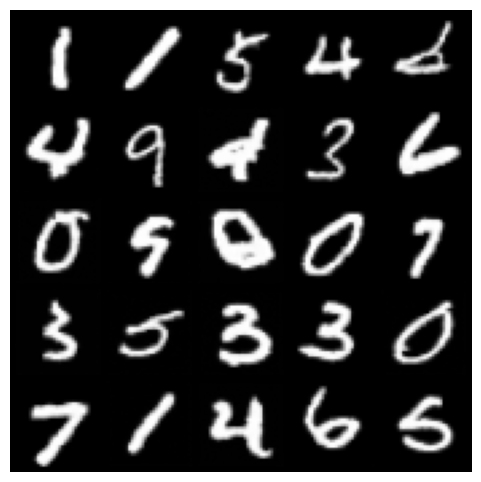

In [15]:
# -----------------------------
# Sampling (DDPM reverse process)
# -----------------------------

@torch.no_grad()
def p_sample_loop(model, n_samples=25):
    model.eval()
    x = torch.randn(n_samples, 1, IMG_SIZE, IMG_SIZE, device=device)

    for i in tqdm(reversed(range(T)), total=T, desc="Sampling", leave=False):
        t = torch.full((n_samples,), i, device=device, dtype=torch.long)
        eps = model(x, t)

        beta_t = extract(betas, t, x.shape)
        sqrt_one_minus_ab_t = extract(sqrt_one_minus_alpha_bar, t, x.shape)
        sqrt_recip_a_t = extract(sqrt_recip_alphas, t, x.shape)

        # μθ(x_t,t) = 1/sqrt(α_t) * (x_t - (β_t / sqrt(1-̄α_t)) * εθ)
        model_mean = sqrt_recip_a_t * (x - beta_t * eps / sqrt_one_minus_ab_t)

        if i == 0:
            x = model_mean
        else:
            var = extract(posterior_variance, t, x.shape)
            x = model_mean + torch.sqrt(var) * torch.randn_like(x)

    return x

samples = p_sample_loop(model, n_samples=25)
samples = (samples.clamp(-1, 1) + 1) / 2  # to [0,1]

grid = make_grid(samples, nrow=5, padding=2)
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.imshow(grid.permute(1, 2, 0).squeeze().cpu(), cmap="gray")
plt.show()
